<a href="https://colab.research.google.com/github/GinuraAdikari/InsightHive/blob/Sentiment_Analysis/ABSA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.0 MB/s eta 0:00:00


#***(A) Aspect Term Extraction***

In [ ]:
import os
import pandas as pd

file_path = "ABSA_dataset.csv"

if os.path.exists(file_path):
    ABSA = pd.read_csv(file_path)
    print("Dataset loaded successfully!")
else:
    raise FileNotFoundError(f"Error: File '{file_path}' not found. Please check the file location.")

Dataset loaded successfully!


In [ ]:
ABSA.head()

,No.,Review_Text,Sentiment_Label,review_length,tokens,Cleaned_review
0,1,one best game music soundtracks game didnt rea...,1,79,"['one', 'best', 'game', 'music', 'soundtrack',...",one best game music soundtrack game didnt real...
1,10001,best purchase ever bought exersaucer little gu...,1,39,"['best', 'purchase', 'ever', 'bought', 'exersa...",best purchase ever bought exersaucer little gu...
2,20001,book slow weak one beststhank god slow weak bo...,0,20,"['book', 'slow', 'weak', 'one', 'beststhank', ...",book slow weak one beststhank god slow weak bo...
3,30001,mustread every southern lady failed love book ...,1,49,"['mustread', 'every', 'southern', 'lady', 'fai...",mustread every southern lady failed love book ...
4,40001,horrible watch napoleon want funny movie sucks...,0,32,"['horrible', 'watch', 'napoleon', 'want', 'fun...",horrible watch napoleon want funny movie suck ...


### ***BERT tokenization for BIO tagging***

In [ ]:
import spacy
import pandas as pd
from tqdm import tqdm
from transformers import BertTokenizerFast

# Load SpaCy model for noun phrase detection
nlp = spacy.load("en_core_web_sm")

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Define predefined aspect terms (these should be domain-specific)
predefined_aspects = {"price", "service", "quality", "food", "music", "book", "game", "movie"}

def bio_tagging(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    tags = ["O"] * len(tokens)

    for i, token in enumerate(tokens):
        if token.lower() in predefined_aspects:
            tags[i] = "B-Aspect"
            if i + 1 < len(tokens) and tokens[i + 1].lower() in predefined_aspects:
                tags[i + 1] = "I-Aspect"

    return tokens, tags

def tokenize_and_align_labels(text, tags):
    tokenized_input = tokenizer(text, padding="max_length", truncation=True, return_tensors="pt")
    word_ids = tokenized_input.word_ids()
    aligned_labels = []
    previous_word = None

    for word_id in word_ids:
        if word_id is None:
            aligned_labels.append(-100)  # Ignored index for loss calculation
        elif word_id != previous_word:
            aligned_labels.append(tags[word_id])
        else:
            aligned_labels.append(tags[word_id] if tags[word_id].startswith("I") else -100)
        previous_word = word_id

    return tokenized_input, aligned_labels

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
tokenized_reviews = []
bio_tags = []
tokenized_inputs = []
aligned_labels_list = []

for review in tqdm(ABSA["Cleaned_review"].dropna()):
    tokens, tags = bio_tagging(review)
    tokenized_reviews.append(tokens)
    bio_tags.append(tags)
    tokenized_input, aligned_labels = tokenize_and_align_labels(" ".join(tokens), tags)
    tokenized_inputs.append(tokenized_input)
    aligned_labels_list.append(aligned_labels)

# Add results to dataframe
ABSA["Tokens"] = tokenized_reviews
ABSA["BIO_Tags"] = bio_tags
ABSA["Tokenized_Inputs"] = tokenized_inputs
ABSA["Aligned_Labels"] = aligned_labels_list

# Save as new CSV
ABSA.to_csv("bio_tagged_dataset.csv", index=False)
print("BIO-tagged dataset with BERT tokenization saved!")

100%|██████████| 1310/1310 [00:25<00:00, 52.24it/s]


BIO-tagged dataset with BERT tokenization saved!


In [ ]:
df = pd.read_csv("bio_tagged_dataset.csv")
df.head()

,No.,Review_Text,Sentiment_Label,review_length,tokens,Cleaned_review,Tokens,BIO_Tags,Tokenized_Inputs,Aligned_Labels
0,1,one best game music soundtracks game didnt rea...,1,79,"['one', 'best', 'game', 'music', 'soundtrack',...",one best game music soundtrack game didnt real...,"['one', 'best', 'game', 'music', 'soundtrack',...","['O', 'O', 'B-Aspect', 'B-Aspect', 'O', 'B-Asp...","{'input_ids': tensor([[ 101, 2028, 2190, 2...","[-100, 'O', 'O', 'B-Aspect', 'B-Aspect', 'O', ..."
1,10001,best purchase ever bought exersaucer little gu...,1,39,"['best', 'purchase', 'ever', 'bought', 'exersa...",best purchase ever bought exersaucer little gu...,"['best', 'purchase', 'ever', 'bought', 'exersa...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...","{'input_ids': tensor([[ 101, 2190, 5309, 2...","[-100, 'O', 'O', 'O', 'O', 'O', -100, -100, -1..."
2,20001,book slow weak one beststhank god slow weak bo...,0,20,"['book', 'slow', 'weak', 'one', 'beststhank', ...",book slow weak one beststhank god slow weak bo...,"['book', 'slow', 'weak', 'one', 'beststhank', ...","['B-Aspect', 'O', 'O', 'O', 'O', 'O', 'O', 'O'...","{'input_ids': tensor([[ 101, 2338, 4030, 5...","[-100, 'B-Aspect', 'O', 'O', 'O', 'O', -100, -..."
3,30001,mustread every southern lady failed love book ...,1,49,"['mustread', 'every', 'southern', 'lady', 'fai...",mustread every southern lady failed love book ...,"['mustread', 'every', 'southern', 'lady', 'fai...","['O', 'O', 'O', 'O', 'O', 'O', 'B-Aspect', 'B-...","{'input_ids': tensor([[ 101, 2442, 16416, 2...","[-100, 'O', -100, -100, 'O', 'O', 'O', 'O', 'O..."
4,40001,horrible watch napoleon want funny movie sucks...,0,32,"['horrible', 'watch', 'napoleon', 'want', 'fun...",horrible watch napoleon want funny movie suck ...,"['horrible', 'watch', 'napoleon', 'want', 'fun...","['O', 'O', 'O', 'O', 'O', 'B-Aspect', 'O', 'B-...","{'input_ids': tensor([[ 101, 9202, 3422, 8...","[-100, 'O', 'O', 'O', 'O', 'O', 'B-Aspect', 'O..."


### ***BERT-NER for Aspect Term Extraction (ATE)***

In [ ]:
from transformers import BertTokenizerFast
import pandas as pd
import ast

# Load dataset
data = pd.read_csv("bio_tagged_dataset.csv")

# ✅ Initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# ✅ Define label mapping
label_map = {"O": 0, "B-Aspect": 1, "I-Aspect": 2}
num_labels = len(label_map)


# Convert stringified lists back to actual lists
data["BIO_Tags"] = data["BIO_Tags"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


# ✅ Function to tokenize and align labels correctly
def tokenize_and_align_labels(sentence, labels):
    # Tokenize while keeping word IDs
    tokenized_input = tokenizer(sentence.split(), truncation=True,
                                is_split_into_words=True, padding="max_length", max_length=128)

    word_ids = tokenized_input.word_ids()  # Get word IDs
    aligned_labels = [-100] * len(tokenized_input["input_ids"])  # Default ignore index

    prev_word = None
    for idx, word_id in enumerate(word_ids):
        if word_id is not None and word_id < len(labels):  # ✅ Check word_id is valid
            if word_id != prev_word:  # ✅ Align only first subword
                aligned_labels[idx] = label_map.get(labels[word_id], 0)  # ✅ Use .get() to avoid KeyError
        prev_word = word_id

    tokenized_input["labels"] = aligned_labels
    return tokenized_input

# ✅ Process entire dataset
tokenized_inputs = []
for i, row in data.iterrows():
    tokenized_inputs.append(tokenize_and_align_labels(row["Cleaned_review"], row["BIO_Tags"]))

# Convert into a DataFrame or Dataset for training
df_tokenized = pd.DataFrame(tokenized_inputs)
df_tokenized.to_csv("tokenized_dataset.csv", index=False)

print("✅ Tokenization completed successfully!")

✅ Tokenization completed successfully!


###***Convert Dataset for BERT-NER Training***

In [ ]:
from transformers import BertTokenizerFast
import ast

# Load tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Convert stringified lists into actual lists
df["BIO_Tags"] = df["BIO_Tags"].apply(ast.literal_eval)

# Define label mapping
label_map = {"O": 0, "B-Aspect": 1, "I-Aspect": 2}
num_labels = len(label_map)

# Function to tokenize and align labels
def tokenize_and_align_labels(sentence, labels):
    tokenized_input = tokenizer(sentence.split(), truncation=True, is_split_into_words=True, padding="max_length", max_length=128)
    aligned_labels = [-100] * len(tokenized_input["input_ids"])  # Default ignore index

    word_ids = tokenized_input.word_ids()  # Get word IDs for alignment
    prev_word = None
    for idx, word_id in enumerate(word_ids):
        if word_id is not None and word_id != prev_word:
            aligned_labels[idx] = label_map[labels[word_id]]
        prev_word = word_id

    tokenized_input["labels"] = aligned_labels
    return tokenized_input

# Process entire dataset
tokenized_inputs = []
for i, row in df.iterrows():
    tokenized_inputs.append(tokenize_and_align_labels(row["Cleaned_review"], row["BIO_Tags"]))  # ✅ No .split()


###***Convert Data to PyTorch Dataset***

In [ ]:
import torch
from torch.utils.data import Dataset

class AspectNERDataset(Dataset):
    def __init__(self, tokenized_inputs):
        self.input_ids = torch.tensor([x["input_ids"] for x in tokenized_inputs], dtype=torch.long)
        self.attention_mask = torch.tensor([x["attention_mask"] for x in tokenized_inputs], dtype=torch.long)
        self.labels = torch.tensor([x["labels"] for x in tokenized_inputs], dtype=torch.long)

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }

# Create dataset object
dataset = AspectNERDataset(tokenized_inputs)

###***Train & Evaluate***

In [ ]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
train_dataset, eval_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

print(f"Train size: {len(train_dataset)}, Eval size: {len(eval_dataset)}")

Train size: 1048, Eval size: 262


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForTokenClassification, Trainer, TrainingArguments

# Load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

tokenized_inputs = {
    "input_ids": [t["input_ids"] for t in tokenized_inputs],
    "attention_mask": [t["attention_mask"] for t in tokenized_inputs]
}

In [ ]:
import os
from transformers import BertForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification

# Disable W&B logging
os.environ["WANDB_DISABLED"] = "true"

# Define label mapping
label_list = ["O", "B-Aspect", "I-Aspect"]
label_map = {label: i for i, label in enumerate(label_list)}

def train_bert_ner(train_dataset, eval_dataset, tokenizer):
    ate_model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(label_map))

    training_args = TrainingArguments(
        output_dir="./bert_ner_model",
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        save_steps=500,
        save_total_limit=2,
        evaluation_strategy="epoch",
        logging_dir="./logs",
        logging_steps=100,
        report_to="none",  # ✅ Disables W&B logging
    )

    data_collator = DataCollatorForTokenClassification(tokenizer)

    trainer = Trainer(
        model=ate_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        processing_class=tokenizer,  # ✅ Fix tokenizer warning
        data_collator=data_collator,
    )

    trainer.train()
    ate_model.save_pretrained("./bert_ner_model")
    tokenizer.save_pretrained("./bert_ner_model")

# Example usage
train_bert_ner(train_dataset, eval_dataset, tokenizer)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,0.078400,0.034816
2,0.036300,0.031758
3,0.028200,0.027703


#### test

In [ ]:
from transformers import BertForTokenClassification, AutoTokenizer
import torch

# Load trained model & tokenizer
ate_model = BertForTokenClassification.from_pretrained("./bert_ner_model")
tokenizer = AutoTokenizer.from_pretrained("./bert_ner_model")

# Set model to evaluation mode
ate_model.eval()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
import re

def extract_aspects(text):
    # Tokenize input
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    # Get predictions
    with torch.no_grad():
        outputs = ate_model(**tokens).logits

    # Convert predictions to labels
    predictions = torch.argmax(outputs, dim=2).squeeze().tolist()

    # Map labels to words
    aspect_terms = []
    for token, label in zip(tokenizer.convert_ids_to_tokens(tokens["input_ids"].squeeze()), predictions):
        if token in ["[CLS]", "[SEP]"]:  # Ignore special tokens
            continue
        if label == 1:  # "B-Aspect"
            aspect_terms.append(token)
        elif label == 2 and aspect_terms:  # "I-Aspect"
            aspect_terms[-1] += " " + token  # Append to previous aspect

    # Remove unwanted characters (like "." at the end)
    aspect_terms = [re.sub(r'\W+$', '', aspect) for aspect in aspect_terms]

    return aspect_terms

In [ ]:
# Test again
sample_review = "The food was delicious but the service was terrible."
aspects = extract_aspects(sample_review)
print("Extracted Aspects:", aspects)

Extracted Aspects: ['food', 'service']


#***(B) Aspect-Based Sentiment Classification***

#### ***Create ABSC Dataset***

In [ ]:
import pandas as pd

# Load the dataset with BIO tags and sentiments
data_ABSC = pd.read_csv("bio_tagged_dataset.csv")  # Update with actual file path

print(data_ABSC.columns)

Index(['No.', 'Review_Text', 'Sentiment_Label', 'review_length', 'tokens',
       'Cleaned_review', 'Tokens', 'BIO_Tags', 'Tokenized_Inputs',
       'Aligned_Labels'],
      dtype='object')


In [ ]:
import ast
import re

# Function to extract unique aspect terms from tokens using BIO tags
def extract_aspects(tokens, bio_tags):
    aspects = set()  # Use a set to store unique aspect terms
    current_aspect = []

    for token, tag in zip(tokens, bio_tags):
        if tag == "B-Aspect":  # Start of an aspect
            if current_aspect:  # Save previous aspect if exists
                aspect_text = " ".join(current_aspect).replace(" ##", "")  # Reconstruct subword tokens
                if is_valid_aspect(aspect_text):  # Filter invalid aspects
                    aspects.add(aspect_text)
                current_aspect = []
            current_aspect.append(token)
        elif tag == "I-Aspect":  # Continuation of an aspect
            current_aspect.append(token)
        else:
            if current_aspect:  # Save the completed aspect
                aspect_text = " ".join(current_aspect).replace(" ##", "")  # Reconstruct subword tokens
                if is_valid_aspect(aspect_text):  # Filter invalid aspects
                    aspects.add(aspect_text)
                current_aspect = []

    # Final check for last aspect
    if current_aspect:
        aspect_text = " ".join(current_aspect).replace(" ##", "")  # Reconstruct subword tokens
        if is_valid_aspect(aspect_text):  # Filter invalid aspects
            aspects.add(aspect_text)

    return list(aspects)  # Convert back to list


def is_valid_aspect(aspect):
    """Checks if an extracted aspect is valid."""
    # Filter out aspects that are too short, consist of only punctuation, or are stopwords
    stopwords = {"the", "a", "an", "and", "or", "is", "was", "were", "this", "that"}
    invalid_tokens = {".", ",", "-", "!", "?"}  # Add any other invalid tokens
    return (
        len(aspect) > 1 and  # Minimum length
        not any(char in invalid_tokens for char in aspect) and  # No invalid tokens
        aspect.lower() not in stopwords  # No stopwords
    )


# Apply function to dataset
data_ABSC["Extracted_Aspects"] = data_ABSC.apply(
    lambda row: extract_aspects(ast.literal_eval(row["Tokens"]), ast.literal_eval(row["BIO_Tags"])), axis=1
)

# Display results
print(data_ABSC[["Review_Text", "Extracted_Aspects", "Sentiment_Label"]].head())

                                         Review_Text Extracted_Aspects  \
0  one best game music soundtracks game didnt rea...     [music, game]   
1  best purchase ever bought exersaucer little gu...           [price]   
2  book slow weak one beststhank god slow weak bo...            [book]   
3  mustread every southern lady failed love book ...            [book]   
4  horrible watch napoleon want funny movie sucks...           [movie]   

   Sentiment_Label  
0                1  
1                1  
2                0  
3                1  
4                0  


In [ ]:
# Convert sentence-level dataset into aspect-level dataset
aspect_data = []
for _, row in data_ABSC.iterrows():
    for aspect in row["Extracted_Aspects"]:
        aspect_data.append({
            "Aspect": aspect,
            "Review_Text": row["Review_Text"],
            "Sentiment_Label": row["Sentiment_Label"]
        })

# Convert into DataFrame
data_ABSC = pd.DataFrame(aspect_data)

# Save for ABSC training
data_ABSC.to_csv("aspect_based_dataset.csv", index=False)

# Display new dataset
print(data_ABSC.head())

  Aspect                                        Review_Text  Sentiment_Label
0  music  one best game music soundtracks game didnt rea...                1
1   game  one best game music soundtracks game didnt rea...                1
2  price  best purchase ever bought exersaucer little gu...                1
3   book  book slow weak one beststhank god slow weak bo...                0
4   book  mustread every southern lady failed love book ...                1


#### ***Tokenizing the Aspect-Review Pairs for BERT***

In [ ]:
from transformers import BertTokenizer
import torch

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Function to tokenize aspect-review pairs
def tokenize_aspect_review(aspect, review):
    encoded = tokenizer(
        f"Aspect: {aspect}. Review: {review}",
        truncation=True,
        padding="max_length",
        max_length=128,  # Adjust as needed
        return_tensors="pt"
    )
    return encoded

# Apply tokenization to the dataset
tokenized_data = data_ABSC.apply(lambda row: tokenize_aspect_review(row["Aspect"], row["Review_Text"]), axis=1)

# Extract input_ids and attention_masks
input_ids = torch.cat([entry["input_ids"] for entry in tokenized_data])
attention_masks = torch.cat([entry["attention_mask"] for entry in tokenized_data])

# Convert sentiment labels to tensor
labels = torch.tensor(data_ABSC["Sentiment_Label"].values)

# Save tokenized dataset
torch.save({"input_ids": input_ids, "attention_masks": attention_masks, "labels": labels}, "absc_tokenized_data.pt")

print("✅ Tokenization complete. Saved as 'absc_tokenized_data.pt'.")

✅ Tokenization complete. Saved as 'absc_tokenized_data.pt'.


####***Preparing DataLoader for Training***

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split

# Load tokenized dataset
data = torch.load("absc_tokenized_data.pt")

# Custom Dataset Class
class ABSCDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],
            "labels": self.labels[idx],
        }

# Initialize dataset
dataset = ABSCDataset(data["input_ids"], data["attention_masks"], data["labels"])

# Split dataset into train (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

# Create DataLoader
batch_size = 8  # Adjust if needed
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"✅ DataLoader prepared: {len(train_dataset)} train samples, {len(val_dataset)} validation samples.")


✅ DataLoader prepared: 562 train samples, 141 validation samples.


<ipython-input-73-f43184ea3c18>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("absc_tokenized_data.pt")


#### ***Define the ABSC Model & Trainer***

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertForSequenceClassification, TrainingArguments, Trainer
from datasets import DatasetDict

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load BERT model for sentiment classification (Binary: Positive/Negative)
absc_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
absc_model.to(device)

# Training arguments
training_args = TrainingArguments(
    output_dir="./absc_model",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True
)

# Convert PyTorch dataset to Hugging Face dataset format
train_dataset_hf = DatasetDict({"train": train_dataset, "validation": val_dataset})

# Define Trainer
trainer = Trainer(
    model=absc_model,
    args=training_args,
    train_dataset=train_dataset_hf["train"],
    eval_dataset=train_dataset_hf["validation"],
)

# Start training
trainer.train()

# Save model
absc_model.save_pretrained("./absc_model")
print("✅ Model training complete & saved!")

Using device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.543600,0.384017
2,0.425200,0.456703
3,0.159600,0.464917


✅ Model training complete & saved!


# ***Evaluate***

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch

# Load trained model
model_path = "./absc_model"  # Update this path if needed
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained("./bert_ner_model")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set to evaluation mode

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
from sklearn.model_selection import train_test_split

# Load aspect-based dataset
data_ABSC = pd.read_csv("aspect_based_dataset.csv")

# Split into train and test (80-20 split)
train_data, test_data = train_test_split(data_ABSC, test_size=0.2, random_state=42)

# Display test set
print(test_data.head())

      Aspect                                        Review_Text  \
495     book  two young women little ones tow meet chance pa...   
164    music  good workout annoying chatter latest addition ...   
54     movie  worth buy recently purchased movie really bad ...   
582    price  exactly says glare fingerprints cant beat pric...   
608  service  pros windows professional looks like installer...   

     Sentiment_Label  
495                0  
164                1  
54                 0  
582                1  
608                1  


In [ ]:
from torch.utils.data import DataLoader
from datasets import Dataset

# Convert test data into Hugging Face Dataset format
def tokenize_data(examples):
    aspect_texts = [" ".join(a) if isinstance(a, list) else a for a in examples["Aspect"]]
    review_texts = [" ".join(r) if isinstance(r, list) else r for r in examples["Review_Text"]]

    return tokenizer(
        [a + " " + r for a, r in zip(aspect_texts, review_texts)],
        truncation=True,
        padding="max_length",
        max_length=128
    )

# Create dataset
test_dataset = Dataset.from_pandas(test_data)
test_dataset = test_dataset.map(tokenize_data, batched=True)
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

# Create DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=8)

# Make predictions
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)

# Add predictions to test data
test_data["Predicted_Label"] = predictions

# Save results
test_data.to_csv("test_results.csv", index=False)
print("Predictions saved to test_results.csv")

Map:   0%|          | 0/141 [00:00<?, ? examples/s]

Predictions saved to test_results.csv


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Convert labels to list
true_labels = test_data["Sentiment_Label"].tolist()
predicted_labels = test_data["Predicted_Label"].tolist()

# Compute metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average="binary")

# Display results
print(f"🔹 Accuracy: {accuracy:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print(f"🔹 F1-score: {f1:.4f}")


🔹 Accuracy: 0.8156
🔹 Precision: 0.8235
🔹 Recall: 0.9130
🔹 F1-score: 0.8660


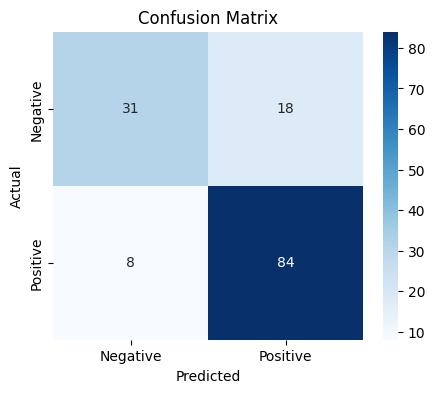

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

<ipython-input-81-3e277f13817a>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(test_dataset["input_ids"])
<ipython-input-81-3e277f13817a>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_masks = torch.tensor(test_dataset["attention_mask"])


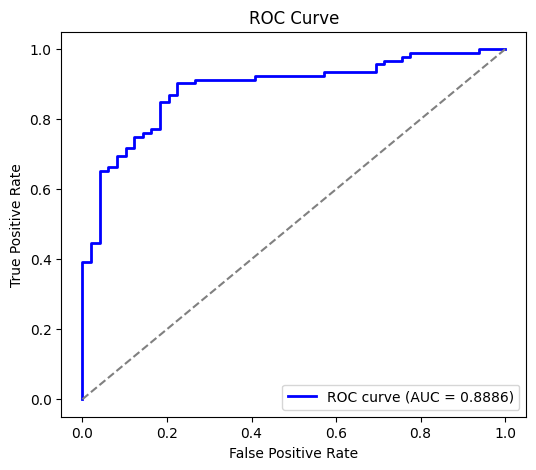

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader, TensorDataset

# Convert test data to tensor dataset
test_inputs = torch.tensor(test_dataset["input_ids"])
test_masks = torch.tensor(test_dataset["attention_mask"])
true_labels = np.array(true_labels)  # Convert labels to numpy

# Create DataLoader to process data in small batches
batch_size = 32  # Adjust if needed
test_data = TensorDataset(test_inputs, test_masks)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Store predictions
positive_probs = []

# Evaluate in batches to prevent memory crash
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        # Get model logits and compute probabilities
        logits = model(input_ids, attention_mask=attention_mask).logits
        probs = torch.softmax(logits, dim=1)[:, 1]  # Probability for positive class

        positive_probs.extend(probs.cpu().numpy())  # Move to CPU and store

# Convert to numpy array
positive_probs = np.array(positive_probs)

# Compute ROC curve
fpr, tpr, _ = roc_curve(true_labels, positive_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
test = pd.read_csv("test_results.csv")
test.head(20)

,Aspect,Review_Text,Sentiment_Label,Predicted_Label
0,book,two young women little ones tow meet chance pa...,0,1
1,music,good workout annoying chatter latest addition ...,1,1
2,movie,worth buy recently purchased movie really bad ...,0,0
3,price,exactly says glare fingerprints cant beat pric...,1,1
4,service,pros windows professional looks like installer...,1,0
5,game,read rate partly inspiring partly imbalanced r...,1,0
6,book,propaganda classic jackson intended stir ameri...,1,1
7,price,ordered item use variety places tractor work l...,0,0
8,game,bought alternate play games instead dragging l...,0,0
9,book,years ago took summer job giving tours hollywo...,1,1


# ***Save***

In [ ]:
# Save ATE model
torch.save(ate_model, "ate_model.pth")

# Save ABSC model
torch.save(absc_model, "absc_model.pth")

# Download the .pth files
from google.colab import files
files.download("ate_model.pth")
files.download("absc_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Test

In [ ]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForTokenClassification, BertForSequenceClassification
from torch.nn.functional import softmax
from tqdm import tqdm

# Load trained NER model (Aspect Term Extraction)
ner_model_path = "./bert_ner_model"
ner_tokenizer = BertTokenizer.from_pretrained(ner_model_path)
ner_model = BertForTokenClassification.from_pretrained(ner_model_path)
ner_model.eval()

# Load trained ABSC model (Aspect-Based Sentiment Classification)
absc_model_path = "./absc_model"
absc_tokenizer = BertTokenizer.from_pretrained(ner_model_path)
absc_model = BertForSequenceClassification.from_pretrained(absc_model_path)
absc_model.eval()

# Aspect label mapping (from NER)
label_map = {0: "O", 1: "B-Aspect", 2: "I-Aspect"}

# ✅ Predefined aspects for ABSA
PREDEFINED_ASPECTS = ["price", "service", "quality", "delivery", "usability",
                      "item", "product", "performance", "support", "refunds"]


def extract_aspects(review):
    """Extracts aspect terms using the NER model."""
    tokens = ner_tokenizer.tokenize(ner_tokenizer.decode(ner_tokenizer.encode(review)))
    inputs = ner_tokenizer.encode_plus(review, return_tensors="pt")

    with torch.no_grad():
        outputs = ner_model(**inputs).logits
        predictions = torch.argmax(outputs, dim=2).squeeze().tolist()

    aspects = []
    current_aspect = []

    for token, label_idx in zip(tokens, predictions[1:-1]):  # Ignore [CLS] and [SEP]
        label = label_map[label_idx]
        if label == "B-Aspect":
            if current_aspect:
                aspects.append(" ".join(current_aspect))
                current_aspect = []
            current_aspect.append(token)
        elif label == "I-Aspect" and current_aspect:
            current_aspect.append(token)
        else:
            if current_aspect:
                aspects.append(" ".join(current_aspect))
                current_aspect = []

    if current_aspect:
        aspects.append(" ".join(current_aspect))

    return aspects


def match_predefined_aspects(extracted_aspects):
    """Matches extracted aspects to predefined ones. Unmatched aspects are ignored."""
    matched_aspects = {aspect: [] for aspect in PREDEFINED_ASPECTS}  # Store sentiment list for each aspect

    for aspect in extracted_aspects:
        aspect_lower = aspect.lower()
        for predefined in PREDEFINED_ASPECTS:
            if predefined in aspect_lower or aspect_lower in predefined:
                matched_aspects[predefined].append(None)  # Placeholder for sentiment prediction

    return matched_aspects


def predict_sentiment(aspect, review):
    """Predicts sentiment for a given aspect in the review."""
    inputs = absc_tokenizer(
        aspect + " " + review,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=128
    )

    with torch.no_grad():
        outputs = absc_model(**inputs).logits
        probabilities = softmax(outputs, dim=-1)
        sentiment = torch.argmax(probabilities, dim=-1).item()

    return sentiment  # 0 = Negative, 1 = Positive


def process_csv(input_csv, output_csv):
    """Processes input CSV, extracts predefined aspects, predicts sentiment, and calculates sentiment percentage."""
    df = pd.read_csv(input_csv)

    # Initialize sentiment count dictionary
    aspect_sentiment_counts = {aspect: {"Positive": 0, "Negative": 0} for aspect in PREDEFINED_ASPECTS}

    for _, row in tqdm(df.iterrows(), total=len(df)):
        review = row["review"]
        extracted_aspects = extract_aspects(review)
        matched_aspects = match_predefined_aspects(extracted_aspects)

        for aspect, sentiments in matched_aspects.items():
            for _ in sentiments:  # Iterate through occurrences of aspect
                sentiment = predict_sentiment(aspect, review)
                sentiment_label = "Positive" if sentiment == 1 else "Negative"
                aspect_sentiment_counts[aspect][sentiment_label] += 1

    # Compute sentiment percentages
    sentiment_percentages = []
    for aspect, counts in aspect_sentiment_counts.items():
        total = counts["Positive"] + counts["Negative"]
        if total > 0:
            positive_percentage = (counts["Positive"] / total) * 100
            negative_percentage = (counts["Negative"] / total) * 100
        else:
            positive_percentage = 0
            negative_percentage = 0

        sentiment_percentages.append({
            "Aspect": aspect,
            "Positive (%)": round(positive_percentage, 2),
            "Negative (%)": round(negative_percentage, 2)
        })

    # Convert to DataFrame and save
    output_df = pd.DataFrame(sentiment_percentages)
    output_df.to_csv(output_csv, index=False)
    print(f"✅ Output saved to {output_csv}")


# 🔥 Run Inference on CSV
input_csv = "reviews.csv"   # Change to your input file
output_csv = "absa_sentiment_distribution.csv"
process_csv(input_csv, output_csv)

100%|██████████| 20/20 [00:05<00:00,  3.44it/s]

✅ Output saved to absa_sentiment_distribution.csv


In [ ]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForTokenClassification, BertForSequenceClassification
from torch.nn.functional import softmax
from tqdm import tqdm

# Load trained NER model (Aspect Term Extraction)
ner_model_path = "./bert_ner_model"
ner_tokenizer = BertTokenizer.from_pretrained(ner_model_path)
ner_model = BertForTokenClassification.from_pretrained(ner_model_path)
ner_model.eval()

# Load trained ABSC model (Aspect-Based Sentiment Classification)
absc_model_path = "./absc_model"
# Use the NER tokenizer for ABSC as well
absc_tokenizer = ner_tokenizer
absc_model = BertForSequenceClassification.from_pretrained(absc_model_path)
absc_model.eval()

# Aspect label mapping (from NER)
label_map = {0: "O", 1: "B-Aspect", 2: "I-Aspect"}


def extract_aspects(review):
    """Extracts aspect terms using the NER model."""
    inputs = ner_tokenizer(review, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    tokens = ner_tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    with torch.no_grad():
        outputs = ner_model(**inputs).logits
        predictions = torch.argmax(outputs, dim=2).squeeze().tolist()

    aspects = []
    current_aspect = []

    for token, label_idx in zip(tokens, predictions):
        if token in ["[CLS]", "[SEP]", "[PAD]"]:  # Ignore special tokens
            continue
        label = label_map[label_idx]
        if label == "B-Aspect":
            if current_aspect:
                aspects.append(" ".join(current_aspect).replace(" ##", ""))
                current_aspect = []
            current_aspect.append(token)
        elif label == "I-Aspect" and current_aspect:
            current_aspect.append(token)
        else:
            if current_aspect:
                aspects.append(" ".join(current_aspect).replace(" ##", ""))
                current_aspect = []

    if current_aspect:
        aspects.append(" ".join(current_aspect).replace(" ##", ""))

    # Filter out invalid aspects (e.g., stopwords)
    stopwords = {"the", "a", "an", "and", "or", "is", "was", "were", "this", "that"}
    aspects = [aspect for aspect in aspects if aspect.lower() not in stopwords]

    return aspects


def predict_sentiment(aspect, review):
    """Predicts sentiment for a given aspect in the review."""
    inputs = absc_tokenizer(
        f"{aspect} [SEP] {review}",  # Use [SEP] to separate aspect and review
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=128
    )

    with torch.no_grad():
        outputs = absc_model(**inputs).logits
        probabilities = softmax(outputs, dim=-1)
        sentiment = torch.argmax(probabilities, dim=-1).item()

    return sentiment  # 0 = Negative, 1 = Positive


def process_csv(input_csv, output_csv):
    """Processes input CSV, extracts aspects, predicts sentiment, and saves output CSV."""
    df = pd.read_csv(input_csv)
    aspect_sentiments = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        review = row["review"]
        aspects = extract_aspects(review)

        for aspect in aspects:
            sentiment = predict_sentiment(aspect, review)
            aspect_sentiments.append({"Review": review, "Aspect": aspect, "Sentiment": sentiment})

    # Convert to DataFrame and save
    output_df = pd.DataFrame(aspect_sentiments)
    output_df["Sentiment"] = output_df["Sentiment"].map({0: "Negative", 1: "Positive"})  # Map labels
    output_df.to_csv(output_csv, index=False)
    print(f"✅ Output saved to {output_csv}")


# 🔥 Run Inference on CSV
input_csv = "reviews.csv"   # Change to your input file
output_csv = "absa_output.csv"
process_csv(input_csv, output_csv)

100%|██████████| 20/20 [00:17<00:00,  1.11it/s]

✅ Output saved to absa_output.csv


In [ ]:
output = pd.read_csv("absa_output.csv")
output.head(10)

,Review,Aspect,Sentiment
0,The price of this product is very reasonable a...,price,Positive
1,The service was terrible; I waited 30 minutes ...,service,Negative
2,The quality of this item is outstanding and wo...,quality,Positive
3,The usability of this software is intuitive an...,.,Positive
4,Price is way too high for the quality provided.,price,Positive
5,Price is way too high for the quality provided.,quality,Positive
6,The service team was very professional and res...,service,Positive
7,I love the quality of this fabric; it's soft a...,quality,Positive


In [ ]:
inputs = ner_tokenizer(review, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
tokens = ner_tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
print(tokens)

['[CLS]', 'the', 'usa', '##bility', 'of', 'this', 'software', 'is', 'intuitive', 'and', 'user', '-', 'friendly', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 

In [ ]:
import torch
from transformers import BertTokenizer, BertForTokenClassification

# Load trained NER model and tokenizer
ner_model_path = "./bert_ner_model"
ner_tokenizer = BertTokenizer.from_pretrained(ner_model_path)
ner_model = BertForTokenClassification.from_pretrained(ner_model_path)
ner_model.eval()  # Set model to evaluation mode

# Example test reviews
test_reviews = [
    "The price of this product is very reasonable and affordable.",
    "The service was terrible; I waited 30 minutes for assistance.",
    "The quality of this item is outstanding and worth every penny.",
    "Delivery was delayed by two weeks, very disappointing.",
    "The usability of this software is intuitive and user-friendly."
]

# Function to extract aspects using NER
def extract_aspects(text):
    tokens = ner_tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = ner_model(**tokens)
    predictions = torch.argmax(outputs.logits, dim=2)

    # Convert token IDs to words
    tokens_list = ner_tokenizer.convert_ids_to_tokens(tokens["input_ids"][0])
    predicted_labels = predictions[0].tolist()

    aspect_terms = []
    for token, label in zip(tokens_list, predicted_labels):
        if label == 1:  # B-Aspect
            aspect_terms.append(token)
        elif label == 2 and aspect_terms:  # I-Aspect
            aspect_terms[-1] += " " + token  # Merge multi-word aspects

    return aspect_terms if aspect_terms else ["Absent"]

# Test NER model
for review in test_reviews:
    aspects = extract_aspects(review)
    print(f"Review: {review}")
    print(f"Extracted Aspects: {aspects}\n")


Review: The price of this product is very reasonable and affordable.
Extracted Aspects: ['price . [SEP]']

Review: The service was terrible; I waited 30 minutes for assistance.
Extracted Aspects: ['service . [SEP]']

Review: The quality of this item is outstanding and worth every penny.
Extracted Aspects: ['quality [SEP]']

Review: Delivery was delayed by two weeks, very disappointing.
Extracted Aspects: ['Absent']

Review: The usability of this software is intuitive and user-friendly.
Extracted Aspects: ['. [SEP]']



In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load trained ABSC model
absc_model_path = "./absc_model"
absc_tokenizer = BertTokenizer.from_pretrained(ner_model_path)
absc_model = BertForSequenceClassification.from_pretrained(absc_model_path)
absc_model.eval()  # Set to evaluation mode

# Example test sentences (manually adding aspect terms)
test_sentences = [
    "The price is too high.",
    "The service was terrible.",
    "The quality is excellent!",
    "Delivery was delayed.",
    "Customer support was great."
]

# Function to predict sentiment
def predict_sentiment(text):
    inputs = absc_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    with torch.no_grad():
        outputs = absc_model(**inputs)
    sentiment = torch.argmax(outputs.logits, dim=1).item()
    return "Positive" if sentiment == 1 else "Negative"

# Test ABSC model
for sentence in test_sentences:
    sentiment = predict_sentiment(sentence)
    print(f"Sentence: {sentence} | Sentiment: {sentiment}")


Sentence: The price is too high. | Sentiment: Negative
Sentence: The service was terrible. | Sentiment: Negative
Sentence: The quality is excellent! | Sentiment: Positive
Sentence: Delivery was delayed. | Sentiment: Negative
Sentence: Customer support was great. | Sentiment: Positive


In [ ]:
from collections import defaultdict

# Sample extracted aspects and their sentiment predictions
aspect_sentiments = {
    "price": ["Positive", "Negative", "Positive"],
    "service": ["Negative", "Positive"],
    "quality": ["Positive", "Positive"],
    "delivery": ["Negative"],
    "usability": ["Positive", "Negative"]
}

# Compute percentage sentiment per aspect
aspect_stats = defaultdict(lambda: {"Positive": 0, "Negative": 0, "Total": 0})

for aspect, sentiments in aspect_sentiments.items():
    for sentiment in sentiments:
        aspect_stats[aspect][sentiment] += 1
        aspect_stats[aspect]["Total"] += 1

# Print results
print("Aspect Sentiment Distribution:")
for aspect, stats in aspect_stats.items():
    pos_pct = (stats["Positive"] / stats["Total"]) * 100
    neg_pct = (stats["Negative"] / stats["Total"]) * 100
    print(f"{aspect}: {pos_pct:.1f}% Positive, {neg_pct:.1f}% Negative")

Aspect Sentiment Distribution:
price: 66.7% Positive, 33.3% Negative
service: 50.0% Positive, 50.0% Negative
quality: 100.0% Positive, 0.0% Negative
delivery: 0.0% Positive, 100.0% Negative
usability: 50.0% Positive, 50.0% Negative


#.

# ***(B.1) ***

In [ ]:
import torch.nn as nn
from transformers import BertModel


In [ ]:
import pandas as pd

# Load BIO-tagged dataset (assuming it has 'tokens', 'bio_tags', 'sentiment')
df = pd.read_csv("bio_tagged_dataset.csv")
df["tokens"] = df["tokens"].apply(eval)  # Convert string lists to actual lists
df["BIO_Tags"] = df["BIO_Tags"].apply(eval)

# Function to extract aspect terms from BIO labels
def extract_aspects(tokens, tags):
    aspects = []
    current_aspect = []

    for token, tag in zip(tokens, tags):
        if "Aspect" in tag:
            if tag.startswith("B-"):
                if current_aspect:
                    aspects.append(" ".join(current_aspect))
                    current_aspect = []
                current_aspect.append(token)
            elif tag.startswith("I-"):
                current_aspect.append(token)
        else:
            if current_aspect:
                aspects.append(" ".join(current_aspect))
                current_aspect = []

    if current_aspect:
        aspects.append(" ".join(current_aspect))

    return aspects

# Create ABSC dataset
absc_data = []
for _, row in df.iterrows():
    sentence = " ".join(row["tokens"])
    aspects = extract_aspects(row["tokens"], row["BIO_Tags"])
    sentiment = row["Sentiment_Label"]  # Overall sentiment label

    for aspect in aspects:
        absc_data.append({"sentence": sentence, "aspect": aspect, "sentiment": sentiment})

# Convert to DataFrame and save
absc_df = pd.DataFrame(absc_data)
absc_df.to_csv("absc_dataset_new.csv", index=False)

print("ABSC dataset created!")

ABSC dataset created!


In [ ]:
absc_df.head(10)

,sentence,aspect,sentiment
0,one best game music soundtrack game didnt real...,game,1
1,one best game music soundtrack game didnt real...,music,1
2,one best game music soundtrack game didnt real...,game,1
3,one best game music soundtrack game didnt real...,music,1
4,one best game music soundtrack game didnt real...,heard,1
5,one best game music soundtrack game didnt real...,soundtrack,1
6,book slow weak one beststhank god slow weak bo...,book,0
7,mustread every southern lady failed love book ...,book,1
8,mustread every southern lady failed love book ...,book,1
9,mustread every southern lady failed love book ...,book,1


In [ ]:
class ABSADataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, sentences, aspects, labels, max_length=128):
        self.tokenizer = tokenizer
        self.sentences = sentences
        self.aspects = aspects
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        aspect = self.aspects[idx]
        label = self.labels[idx]

        # Tokenize sentence and aspect
        sentence_enc = self.tokenizer(
            sentence,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        aspect_enc = self.tokenizer(
            aspect,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )

        return {
            "input_ids": sentence_enc["input_ids"].squeeze(),
            "attention_mask": sentence_enc["attention_mask"].squeeze(),
            "aspect_input_ids": aspect_enc["input_ids"].squeeze(),
            "aspect_attention_mask": aspect_enc["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long),
        }

In [ ]:
class BertForABSA(nn.Module):
    def __init__(self, model_name="bert-base-uncased", num_labels=2):
        super(BertForABSA, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.aspect_attention = nn.Linear(self.bert.config.hidden_size, 1)  # Attention Layer
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)  # Sentiment classifier

    def forward(self, input_ids, attention_mask, aspect_input_ids, aspect_attention_mask, labels=None):
        # Get sentence embeddings
        sentence_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sentence_hidden_states = sentence_outputs.last_hidden_state  # Shape: (batch_size, seq_length, hidden_size)

        # Get aspect embeddings
        aspect_outputs = self.bert(input_ids=aspect_input_ids, attention_mask=aspect_attention_mask)
        aspect_embedding = aspect_outputs.last_hidden_state[:, 0, :]  # Get [CLS] token of aspect

        # Generate attention scores based on aspect
        attention_scores = torch.tanh(self.aspect_attention(sentence_hidden_states))  # Shape: (batch, seq, 1)
        attention_weights = torch.softmax(attention_scores, dim=1)  # Normalize over sequence

        # Weighted sum of hidden states
        context_vector = torch.sum(attention_weights * sentence_hidden_states, dim=1)  # (batch, hidden_size)

        logits = self.classifier(self.dropout(context_vector))  # Output sentiment logits

        # Calculate loss if labels are provided:
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
          return loss  # Return the loss during training
        else:
          return logits  # Return logits for inference

In [ ]:
import time
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

def train(model, train_loader, val_loader, optimizer, criterion, epochs=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)  # Move model to GPU/CPU

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss = 0
        start_time = time.time()

        for batch_idx, batch in enumerate(train_loader):
            optimizer.zero_grad()

            # Move batch to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            aspect_input_ids = batch["aspect_input_ids"].to(device)
            aspect_attention_mask = batch["aspect_attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                aspect_input_ids=aspect_input_ids,
                aspect_attention_mask=aspect_attention_mask,
                labels=labels,  # Ensure the model is aware of labels
            )

            loss = outputs.loss if hasattr(outputs, "loss") else criterion(outputs.logits, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Print loss every 10 batches
            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1} | Batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}")

        avg_train_loss = total_loss / len(train_loader)
        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch+1} Completed | Avg Train Loss: {avg_train_loss:.4f} | Time: {elapsed_time:.2f}s")

        # Validation phase
        model.eval()
        val_preds, val_labels = [], []
        val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                aspect_input_ids = batch["aspect_input_ids"].to(device)
                aspect_attention_mask = batch["aspect_attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    aspect_input_ids=aspect_input_ids,
                    aspect_attention_mask=aspect_attention_mask,
                )

                logits = outputs.logits
                loss = criterion(logits, labels)
                val_loss += loss.item()

                preds = torch.argmax(logits, dim=-1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average="weighted")

        print(f"Epoch {epoch+1} | Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.4f} | Val F1: {val_f1:.4f}")

    print("Training complete!")

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

# Load the ABSC dataset
absc_df = pd.read_csv("absc_dataset_new.csv")

# Split into train and validation sets
train_df, val_df = train_test_split(absc_df, test_size=0.2, random_state=42)

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Create datasets
train_dataset = ABSADataset(tokenizer, train_df["sentence"].tolist(), train_df["aspect"].tolist(), train_df["sentiment"].tolist())
val_dataset = ABSADataset(tokenizer, val_df["sentence"].tolist(), val_df["aspect"].tolist(), val_df["sentiment"].tolist())

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Initialize the ABSC model
model = BertForABSA(num_labels=2)  # Assuming 2 sentiment : negative, neutral, positive

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Start training
train(model, train_loader, val_loader, optimizer, criterion, epochs=3)

AttributeError: 'BertForABSA' object has no attribute 'num_labels'

# A

### Bio tagging

#### load dataset

In [ ]:
import os
import pandas as pd

file_path = "ABSA_dataset.csv"

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully!")
else:
    raise FileNotFoundError(f"Error: File '{file_path}' not found. Please check the file location.")

Dataset loaded successfully!


#### appply bio tagging

In [ ]:
import spacy
from transformers import BertTokenizer

# Load models
nlp = spacy.load("en_core_web_sm")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Function to generate BIO tags
def generate_bio_tags(sentence):
    tokens = tokenizer.tokenize(sentence)
    bio_tags = ["O"] * len(tokens)  # Default to "O"

    # Use SpaCy to find noun chunks (potential aspects)
    doc = nlp(sentence)
    for chunk in doc.noun_chunks:
        chunk_tokens = tokenizer.tokenize(chunk.text)

        # Find where the chunk starts in BERT tokens
        for i in range(len(tokens) - len(chunk_tokens) + 1):
            if tokens[i:i + len(chunk_tokens)] == chunk_tokens:
                bio_tags[i] = "B-Aspect"  # First token is "B-Aspect"
                for j in range(1, len(chunk_tokens)):
                    bio_tags[i + j] = "I-Aspect"  # Rest are "I-Aspect"
                break

    return tokens, bio_tags

# Example usage
sentence = "best game music soundtrack"
tokens, tags = generate_bio_tags(sentence)
print(list(zip(tokens, tags)))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[('best', 'B-Aspect'), ('game', 'I-Aspect'), ('music', 'I-Aspect'), ('soundtrack', 'I-Aspect')]


In [ ]:
from tqdm import tqdm

# Apply BIO tagging to each review
bio_data = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    sentence = row["Cleaned_review"]
    tokens, bio_tags = generate_bio_tags(sentence)

    bio_data.append({
        "tokens": tokens,
        "bio_tags": bio_tags,
        "sentiment": row["Sentiment_Label"]  # Keep sentiment label for later training
    })

# Convert to DataFrame
bio_df = pd.DataFrame(bio_data)

# Save to a CSV file
bio_df.to_csv("bio_labeled_dataset.csv", index=False)

print("BIO-tagged dataset saved as 'bio_labeled_dataset.csv'")

100%|██████████| 1310/1310 [00:24<00:00, 53.36it/s]


BIO-tagged dataset saved as 'bio_labeled_dataset.csv'


In [ ]:
bio_df.head()

,tokens,bio_tags,sentiment
0,"[one, best, game, music, soundtrack, game, did...","[B-Aspect, I-Aspect, I-Aspect, I-Aspect, I-Asp...",1
1,"[best, purchase, ever, bought, ex, ##ers, ##au...","[B-Aspect, I-Aspect, O, O, B-Aspect, I-Aspect,...",1
2,"[book, slow, weak, one, best, ##st, ##han, ##k...","[B-Aspect, B-Aspect, I-Aspect, I-Aspect, I-Asp...",0
3,"[must, ##rea, ##d, every, southern, lady, fail...","[O, O, O, B-Aspect, I-Aspect, I-Aspect, O, B-A...",1
4,"[horrible, watch, napoleon, want, funny, movie...","[B-Aspect, I-Aspect, I-Aspect, O, B-Aspect, I-...",0


### BERT-based NER model

#### bio data -> ner format

In [ ]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the BIO-tagged dataset
df = pd.read_csv("bio_labeled_dataset.csv")

# Convert list strings back to actual lists
df["tokens"] = df["tokens"].apply(eval)
df["bio_tags"] = df["bio_tags"].apply(eval)

# Split data into train and validation sets
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)

# Function to save in JSON format for training
def save_ner_json(data, filename):
    formatted_data = []
    for _, row in data.iterrows():
        tokens = row["tokens"]
        tags = row["bio_tags"]
        formatted_data.append({"tokens": tokens, "ner_tags": tags})

    with open(filename, "w") as f:
        json.dump(formatted_data, f, indent=4)

# Save train and validation data
save_ner_json(train_data, "train_ner.json")
save_ner_json(val_data, "val_ner.json")

print("Training and validation data saved in JSON format.")

Training and validation data saved in JSON format.


#### fine tune bert for ner

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
import torch
from datasets import load_dataset, DatasetDict

# Load the dataset
dataset = DatasetDict({
    "train": load_dataset("json", data_files="train_ner.json")["train"],
    "validation": load_dataset("json", data_files="val_ner.json")["train"]
})

print(dataset['train'][0])

{'tokens': ['faulty', 'product', 'arrived', 'timely', 'manner', 'would', 'great', 'item', 'accept', '##ion', 'drill', 'hole', 'stock', 'sw', '##ive', '##l', 'bolt', 'didn', '##t', 'hole', 'install', 'sw', '##ive', '##l'], 'ner_tags': ['B-Aspect', 'I-Aspect', 'O', 'O', 'O', 'O', 'B-Aspect', 'I-Aspect', 'I-Aspect', 'I-Aspect', 'I-Aspect', 'I-Aspect', 'I-Aspect', 'I-Aspect', 'I-Aspect', 'I-Aspect', 'I-Aspect', 'O', 'O', 'O', 'B-Aspect', 'I-Aspect', 'I-Aspect', 'I-Aspect']}


tokenization & label alignment

In [ ]:
from transformers import BertTokenizerFast

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

label_list = ["O", "B-Aspect", "I-Aspect"]  # Define all unique labels
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

def tokenize_and_align_labels(example):
    tokenized = tokenizer(example["tokens"], truncation=True, is_split_into_words=True, padding="max_length", max_length=128)
    labels = [label2id[tag] for tag in example["ner_tags"]]
    tokenized["labels"] = labels + [0] * (128 - len(labels))  # Padding labels to match input length
    return tokenized

# Apply tokenization to dataset
dataset = dataset.map(tokenize_and_align_labels, batched=True)

print("Tokenization complete!")

Map:   0%|          | 0/1048 [00:00<?, ? examples/s]

TypeError: unhashable type: 'list'

train

In [ ]:
from transformers import BertTokenizerFast, BertForTokenClassification, Trainer, TrainingArguments

model = BertForTokenClassification.from_pretrained("bert-base-uncased",
                                                   num_labels=len(label_list),
                                                   label2id=label2id,
                                                   label2id=label2id)  # B-Aspect, I-Aspect, O

# Training setup
training_args = TrainingArguments(
    output_dir="./bert_ner",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer
)

# Train model
trainer.train()

# Save trained model
model.save_pretrained("aspect_ner_model")
tokenizer.save_pretrained("aspect_ner_model")
print("Model training complete and saved!")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1048 [00:00<?, ? examples/s]

KeyError: 'bio_tags'

#### aspect extraction using trained model

In [ ]:
from transformers import BertForTokenClassification, BertTokenizerFast
import torch

# Load trained model
model_path = "aspect_ner_model"
model = BertForTokenClassification.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(model_path)

# Function to extract aspects
def extract_aspects(text):
    tokens = tokenizer.tokenize(text)
    inputs = tokenizer.encode(text, return_tensors="pt")
    outputs = model(inputs).logits
    predictions = torch.argmax(outputs, dim=2)

    aspect_terms = []
    current_aspect = []
    for token, pred in zip(tokens, predictions[0].tolist()):
        label = id2label[pred]
        if label == "B-Aspect":
            if current_aspect:
                aspect_terms.append(" ".join(current_aspect))
            current_aspect = [token]
        elif label == "I-Aspect":
            current_aspect.append(token)
        else:
            if current_aspect:
                aspect_terms.append(" ".join(current_aspect))
                current_aspect = []
    if current_aspect:
        aspect_terms.append(" ".join(current_aspect))

    return aspect_terms

# Example usage
text = "This laptop has an amazing battery life but a terrible keyboard."
print("Extracted Aspects:", extract_aspects(text))